The goal in this notebook is to find the number of trials at which the trial power and the abs effect size difference
(untreated - treated) converge. Convergence should take place for all outcomes (obtained from either linear or logistic regression)

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
#pd.set_option('max_rows', None)
#pd.set_option('max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.4f}'.format
import numpy as np

In [2]:
resultsDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/SIMULATIONS/CONVERGENCE-OF-TRIALSET-RESULTS/RUN-100-TRIALS/RUN-5"
os.chdir(resultsDir)
results=pd.read_csv("results.csv")

In [3]:
results.head()

,reg,se,pvalue,intercept,meanUntreated,meanTreated,duration,sampleSize,outcome,analysis,OutcomeModelType.DEMENTIA,OutcomeModelType.CARDIOVASCULAR
0,-0.0090,0.0284,0.7516,-0.1655,0.4587,0.4565,3,20000,death-stroke-mi-dementia-ci-,logisticRegression-death-stroke-mi-dementia-ci-,0.0154,0.0101
1,-0.0794,0.0585,0.1744,-2.6690,0.0648,0.0602,3,20000,ci-dementia-,logisticRegression-ci-dementia-,0.0154,0.0101
2,-0.0177,0.0300,0.5554,-0.6939,0.3332,0.3292,3,20000,death-,logisticRegression-death-,0.0154,0.0101
3,-0.0085,0.0287,0.7686,-0.3515,0.4130,0.4110,3,20000,death-stroke-mi-,logisticRegression-death-stroke-mi-,0.0154,0.0101
4,0.0028,0.0095,0.7720,1.6611,1.6611,1.6639,3,20000,_qalys-sum,linearRegression-_qalys-sum,0.0154,0.0101


In [4]:
results["significant"] = (results["pvalue"]<0.05).astype(int)
results["absEffectSizeDiff"] = results["meanUntreated"] - results["meanTreated"]

In [5]:
results.shape

(58800, 14)

In [6]:
#how many regressions returned nan in absolute number and percent wise 
results["reg"].isna().sum(),results["reg"].isna().sum()/results.shape[0]

(6517, 0.11083333333333334)

In [7]:
#from now on keep rows without nan
results = results.dropna(axis=0).copy()

In [8]:
outcomes=results["outcome"].unique()
dementiaRisks=results["OutcomeModelType.DEMENTIA"].unique()
cvRisks=results["OutcomeModelType.CARDIOVASCULAR"].unique()
sampleSizes=results["sampleSize"].unique()
durations=results["duration"].unique()

In [9]:
outcomes, dementiaRisks, cvRisks, sampleSizes, durations

(array(['death-stroke-mi-dementia-ci-', 'ci-dementia-', 'death-',
        'death-stroke-mi-', '_qalys-sum', '_gcp-mean', '_gcp-last'],
       dtype=object),
 array([0.01538098]),
 array([0.01010065]),
 array([20000,   500,  1000,  2000,  4000,  6000,  8000, 10000, 15000]),
 array([ 3,  5, 10, 15, 20]))

In [10]:
linearModelOutcomes = outcomes[4:]
logisticModelOutcomes = outcomes[0:4]

In [11]:
#dictionary, key depends on outcome, duration and sample size, value is an array with cv=row, dem=column
meanAbsEffectSizeDiff={} 
meanTrialPower={}
#initialize the running mean regression column in the results dataframe
results["runMeanAbsEffectSizeDiff"]=np.nan
results["runMeanTrialPower"]=np.nan
#initialize temporary pandas series to store the running mean regression
runMeanAbsEffectSizeDiff = None
runMeanTrialPower = None

In [12]:
%%time
#calculate means and running means for regression
#it takes a few minutes (but not unreasonably long)
for outcome in outcomes:    
    for duration in durations:
        for sampleSize in sampleSizes:
            #initialize array for specific outcome, duration, sample size
            meanAbsEffectSizeDiff[f"{outcome},{duration},{sampleSize}"]=np.zeros((len(cvRisks),len(dementiaRisks)))
            meanTrialPower[f"{outcome},{duration},{sampleSize}"]=np.zeros((len(cvRisks),len(dementiaRisks)))
            for iCvRisk in range(len(cvRisks)):
                for iDementiaRisk in range(len(dementiaRisks)):
                    
                    dfForParameters=results.loc[ #get all relevant data
                                    (results["outcome"]==outcome) & 
                                    (results["sampleSize"]==sampleSize) &
                                    (results["OutcomeModelType.DEMENTIA"]==dementiaRisks[iDementiaRisk]) & 
                                    (results["OutcomeModelType.CARDIOVASCULAR"]==cvRisks[iCvRisk]) &
                                    (results["duration"]==duration) ]
                    
                    sigs=dfForParameters["significant"].copy()
                    meanTrialPower[f"{outcome},{duration},{sampleSize}"][iCvRisk,iDementiaRisk]=sigs.mean()
                    
                    absEffectSizeDiff=dfForParameters["absEffectSizeDiff"].copy() 
                    meanAbsEffectSizeDiff[f"{outcome},{duration},{sampleSize}"][iCvRisk,iDementiaRisk]=absEffectSizeDiff.mean() 
        
                    #calculate and store running means
                    if runMeanAbsEffectSizeDiff is None:
                        runMeanAbsEffectSizeDiff=absEffectSizeDiff.expanding().mean()
                    else:
                        runMeanAbsEffectSizeDiff=pd.concat([runMeanAbsEffectSizeDiff,absEffectSizeDiff.expanding().mean()])
                    
                    if runMeanTrialPower is None:
                        runMeanTrialPower=sigs.expanding().mean()
                    else:
                        runMeanTrialPower=pd.concat([runMeanTrialPower,sigs.expanding().mean()])

#store running means in results dataframe
#even though the rows in runMeanAbsEffectSizeDiff and runMeanTrialPower are not in the same order as the results DF,
#pandas uses the index to assign the values to the appropriate index and row
results["runMeanAbsEffectSizeDiff"]=runMeanAbsEffectSizeDiff 
results["runMeanTrialPower"]=runMeanTrialPower 
                    

CPU times: user 755 ms, sys: 8.96 ms, total: 764 ms
Wall time: 763 ms


In [13]:
import statsmodels.api as sm

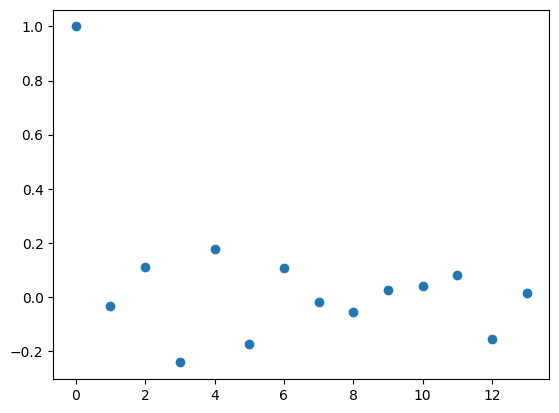

In [14]:
acf = sm.tsa.acf(results.loc[(results["outcome"]==outcomes[4]) & 
            (results["sampleSize"]==max(sampleSizes)) &
            (results["duration"]==max(durations)),"se"
            ])
plt.scatter(range(len(acf)),acf)

In [15]:
sampleSizes, durations

(array([20000,   500,  1000,  2000,  4000,  6000,  8000, 10000, 15000]),
 array([ 3,  5, 10, 15, 20]))

In [16]:
results.loc[(results["outcome"]==outcomes[4]) & 
            (results["sampleSize"]==sampleSizes[0]) &
            (results["duration"]==durations[4]),"reg"
            ]

2356     0.0307
5296     0.0115
8236    -0.0008
11176   -0.0051
14116    0.0623
17056    0.0253
19996    0.0707
22936   -0.0270
25876    0.0069
28816    0.0043
31756    0.0675
34696   -0.0185
37636   -0.0151
40576   -0.0079
43516   -0.0046
46456    0.0118
49396   -0.0264
52336    0.0155
55276   -0.0179
58216   -0.0267
Name: reg, dtype: float64

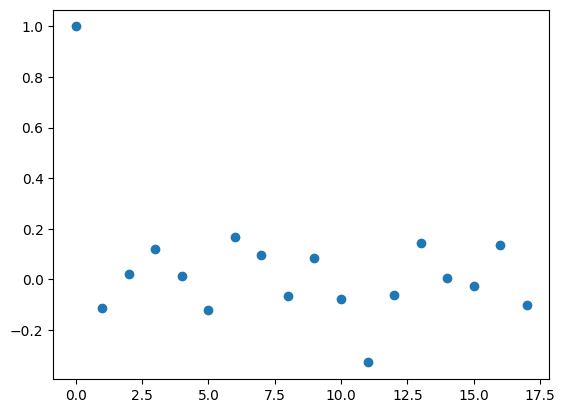

In [20]:
acf = sm.tsa.acf(results.loc[(results["outcome"]==outcomes[1]) & 
            (results["sampleSize"]==sampleSizes[5]) &
            (results["duration"]==durations[0]),"reg"
            ])
plt.scatter(range(len(acf)),acf)

In [21]:
results.loc[(results["outcome"]==outcomes[5]) & 
            (results["sampleSize"]==max(sampleSizes)) &
            (results["duration"]==max(durations))]

,reg,se,pvalue,intercept,meanUntreated,meanTreated,duration,sampleSize,outcome,analysis,OutcomeModelType.DEMENTIA,OutcomeModelType.CARDIOVASCULAR,significant,absEffectSizeDiff,runMeanAbsEffectSizeDiff,runMeanTrialPower
2357,0.0389,0.0516,0.4500,32.9947,32.9947,33.0336,20,20000,_gcp-mean,linearRegression-_gcp-mean,0.0154,0.0101,0,-0.0389,-0.0389,0.0000
5297,-0.0107,0.0512,0.8341,33.0830,33.0830,33.0723,20,20000,_gcp-mean,linearRegression-_gcp-mean,0.0154,0.0101,0,0.0107,-0.0141,0.0000
8237,0.0115,0.0520,0.8248,33.0181,33.0181,33.0296,20,20000,_gcp-mean,linearRegression-_gcp-mean,0.0154,0.0101,0,-0.0115,-0.0132,0.0000
11177,0.1075,0.0518,0.0378,32.9688,32.9688,33.0763,20,20000,_gcp-mean,linearRegression-_gcp-mean,0.0154,0.0101,1,-0.1075,-0.0368,0.2500
14117,0.0191,0.0516,0.7110,33.0095,33.0095,33.0287,20,20000,_gcp-mean,linearRegression-_gcp-mean,0.0154,0.0101,0,-0.0191,-0.0333,0.2000
17057,0.0191,0.0514,0.7098,33.0214,33.0214,33.0405,20,20000,_gcp-mean,linearRegression-_gcp-mean,0.0154,0.0101,0,-0.0191,-0.0309,0.1667
19997,-0.0465,0.0515,0.3657,33.0351,33.0351,32.9885,20,20000,_gcp-mean,linearRegression-_gcp-mean,0.0154,0.0101,0,0.0465,-0.0199,0.1429
22937,-0.0368,0.0516,0.4764,33.0535,33.0535,33.0167,20,20000,_gcp-mean,linearRegression-_gcp-mean,0.0154,0.0101,0,0.0368,-0.0128,0.1250
25877,0.0923,0.0523,0.0772,32.9585,32.9585,33.0508,20,20000,_gcp-mean,linearRegression-_gcp-mean,0.0154,0.0101,0,-0.0923,-0.0216,0.1111
28817,0.0114,0.0516,0.8248,33.0003,33.0003,33.0117,20,20000,_gcp-mean,linearRegression-_gcp-mean,0.0154,0.0101,0,-0.0114,-0.0206,0.1000


In [22]:
np.sort(results.loc[(results["outcome"]==outcomes[5]) & 
            (results["sampleSize"]==max(sampleSizes)) &
            (results["duration"]==max(durations)),"reg"
            ].unique())

array([-0.0669997 , -0.05971923, -0.04654008, -0.03676998, -0.03506589,
       -0.0277174 , -0.01071553, -0.00449259,  0.00079937,  0.00562866,
        0.01141562,  0.01151838,  0.01912139,  0.01913696,  0.03894336,
        0.0414334 ,  0.04441513,  0.09234629,  0.10752628,  0.10980535])

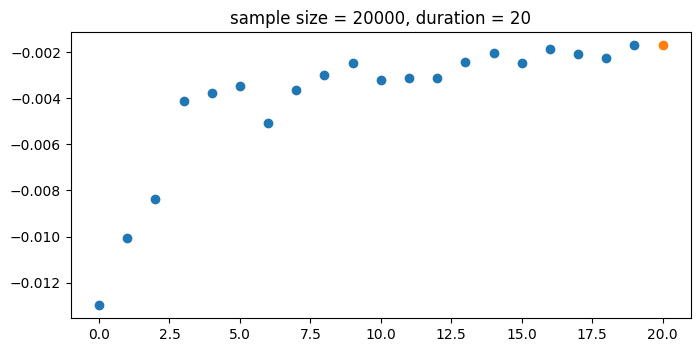

In [26]:
outcome = outcomes[1]

nPlots = len(durations) * len(sampleSizes) * len(dementiaRisks) * len(cvRisks)

fig = plt.figure(figsize=(8,200))

i = 1
for duration in [max(durations)]: 
    #for sampleSize in sampleSizes: #plot for all sample sizes
    for sampleSize in [max(sampleSizes)]:
        #print(sampleSize, duration)
        nPoints = 20 * (max(sampleSizes) // sampleSize) 
        for iCvRisk in [0]: #set a specific risk, 0-4            
            for iDementiaRisk in [0]: #set a specific dementia risk, 0-4
                plotData=results.loc[ #get all relevant data
                    (results["outcome"]==outcome) & 
                    (results["sampleSize"]==sampleSize) &
                    (results["OutcomeModelType.DEMENTIA"]==dementiaRisks[iDementiaRisk]) & 
                    (results["OutcomeModelType.CARDIOVASCULAR"]==cvRisks[iCvRisk]) &
                    (results["duration"]==duration), "runMeanAbsEffectSizeDiff"].copy()
                plt.subplot(nPlots,1,i)  
                plt.title(f"sample size = {sampleSize}, duration = {duration}")
                plt.scatter(range(len(plotData)),plotData)
                plt.scatter(nPoints,meanAbsEffectSizeDiff[f"{outcome},{duration},{sampleSize}"][iCvRisk,iDementiaRisk])
                i = i+1
plt.show()
